In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)

- floor==0 -> IsBasement ==True
- floor==1 -> IsBasement ==False

In [4]:
data[["county", "log_radon", "floor"]].head()

county  log_radon  floor
0  AITKIN   0.832909    1.0
1  AITKIN   0.832909    0.0
2  AITKIN   1.098612    0.0
3  AITKIN   0.095310    0.0
4   ANOKA   1.163151    0.0

In [5]:
data["county"].unique()

array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

<AxesSubplot:title={'center':'log_radon'}, xlabel='county'>

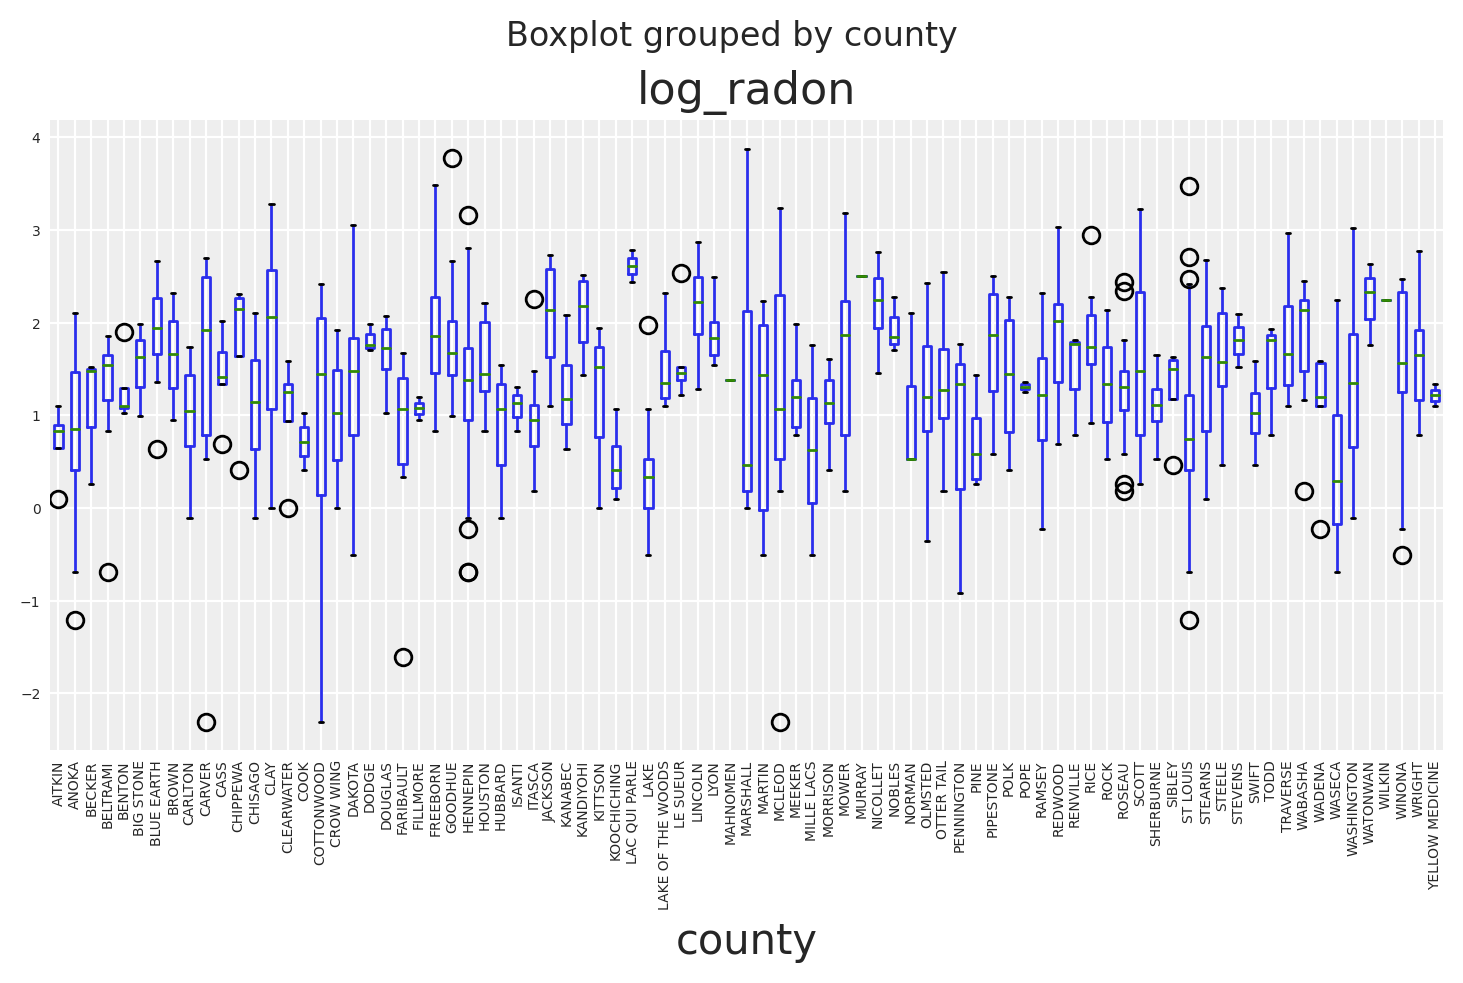

In [6]:
data.boxplot("log_radon",by="county", rot=90, fontsize=5)

In [7]:
data[["county", "log_radon", "floor"]].describe()

log_radon       floor
count  919.000000  919.000000
mean     1.264779    0.166485
std      0.819355    0.372719
min     -2.302585    0.000000
25%      0.693147    0.000000
50%      1.308333    0.000000
75%      1.808289    0.000000
max      3.877432    1.000000

In [8]:
data["county"].value_counts()[["CASS", "CROW WING", "FREEBORN"]]

CASS          5
CROW WING    12
FREEBORN      9
Name: county, dtype: int64

$$ radon_{i,c}=\alpha_c + \beta_c \times floor_{i,c} + \epsilon_c $$

$$\alpha_c = N(\mu_\alpha, \sigma^2_\alpha)$$
$$\beta_c = N(\mu_\beta, \sigma^2_\beta)$$

In [9]:
county_idxs, counties = pd.factorize(data.county)
print("len_county_idxs:",len(county_idxs))
print("county_idxs:",county_idxs)
print("len_counties:",len(counties))
print("counties:",counties)


len_county_idxs: 919
county_idxs: [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  3  3  3  3  3  3  3  4  4  4  4  5  5
  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  8  8  8  8  8
  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 11 11 11 11 12 12 12 12
 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 15 15 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 19 19 19 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 22
 22 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 2

In [10]:
counties.get_loc("BECKER")


2

In [11]:
county_idxs, counties = pd.factorize(data.county)

coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}
coords

{'county': Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
        'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
        'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
        'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
        'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
        'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
        'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
        'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
        'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
        'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
        'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
        'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
        'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
        'WASECA', 'WASHINGTO

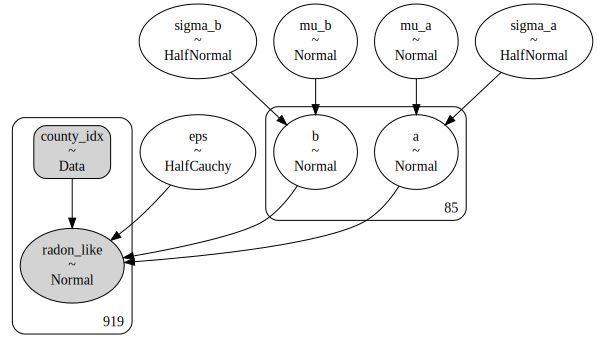

In [22]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
    # effect difference between basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id"
    )
    
pm.model_to_graphviz(hierarchical_model)

In [23]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 71 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8084721587105893, but should be close to 0.9. Try to increase the number of tuning steps.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9757457913237925, but should be close to 0.9. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8393475422090335, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

/tmp/ipykernel_1229/3884850394.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(hierarchical_trace)


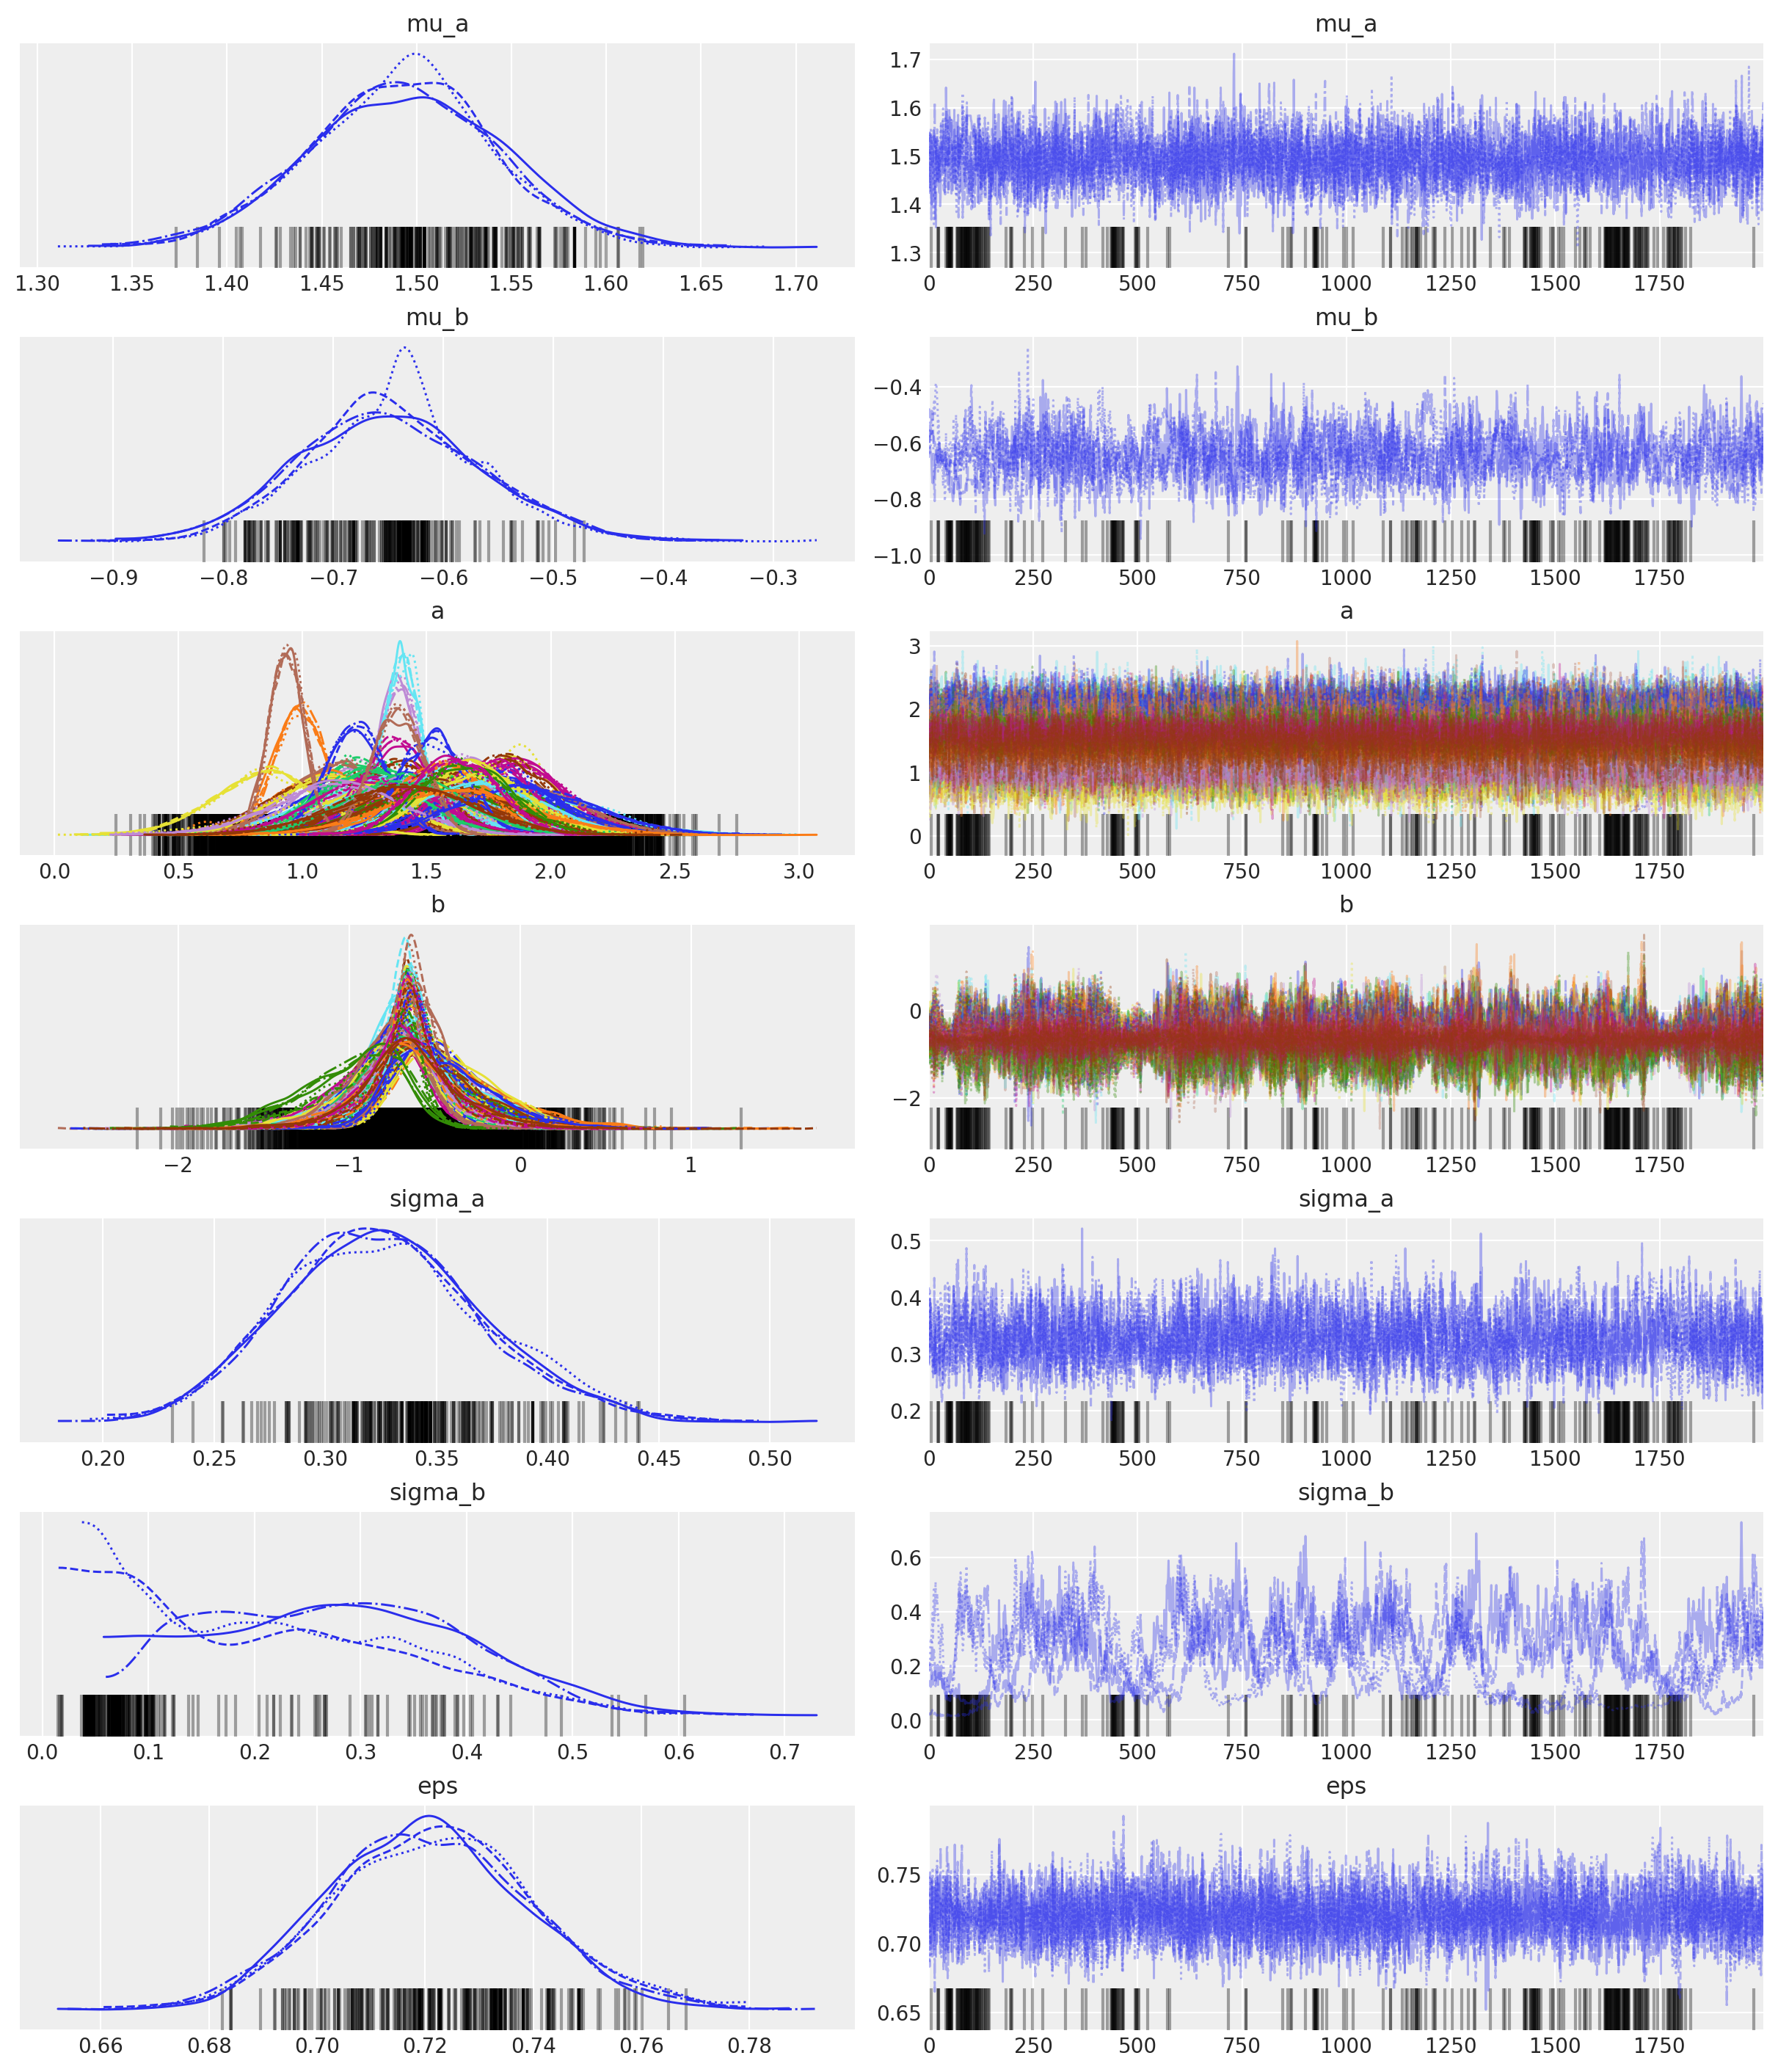

In [24]:
_ = pm.traceplot(hierarchical_trace)

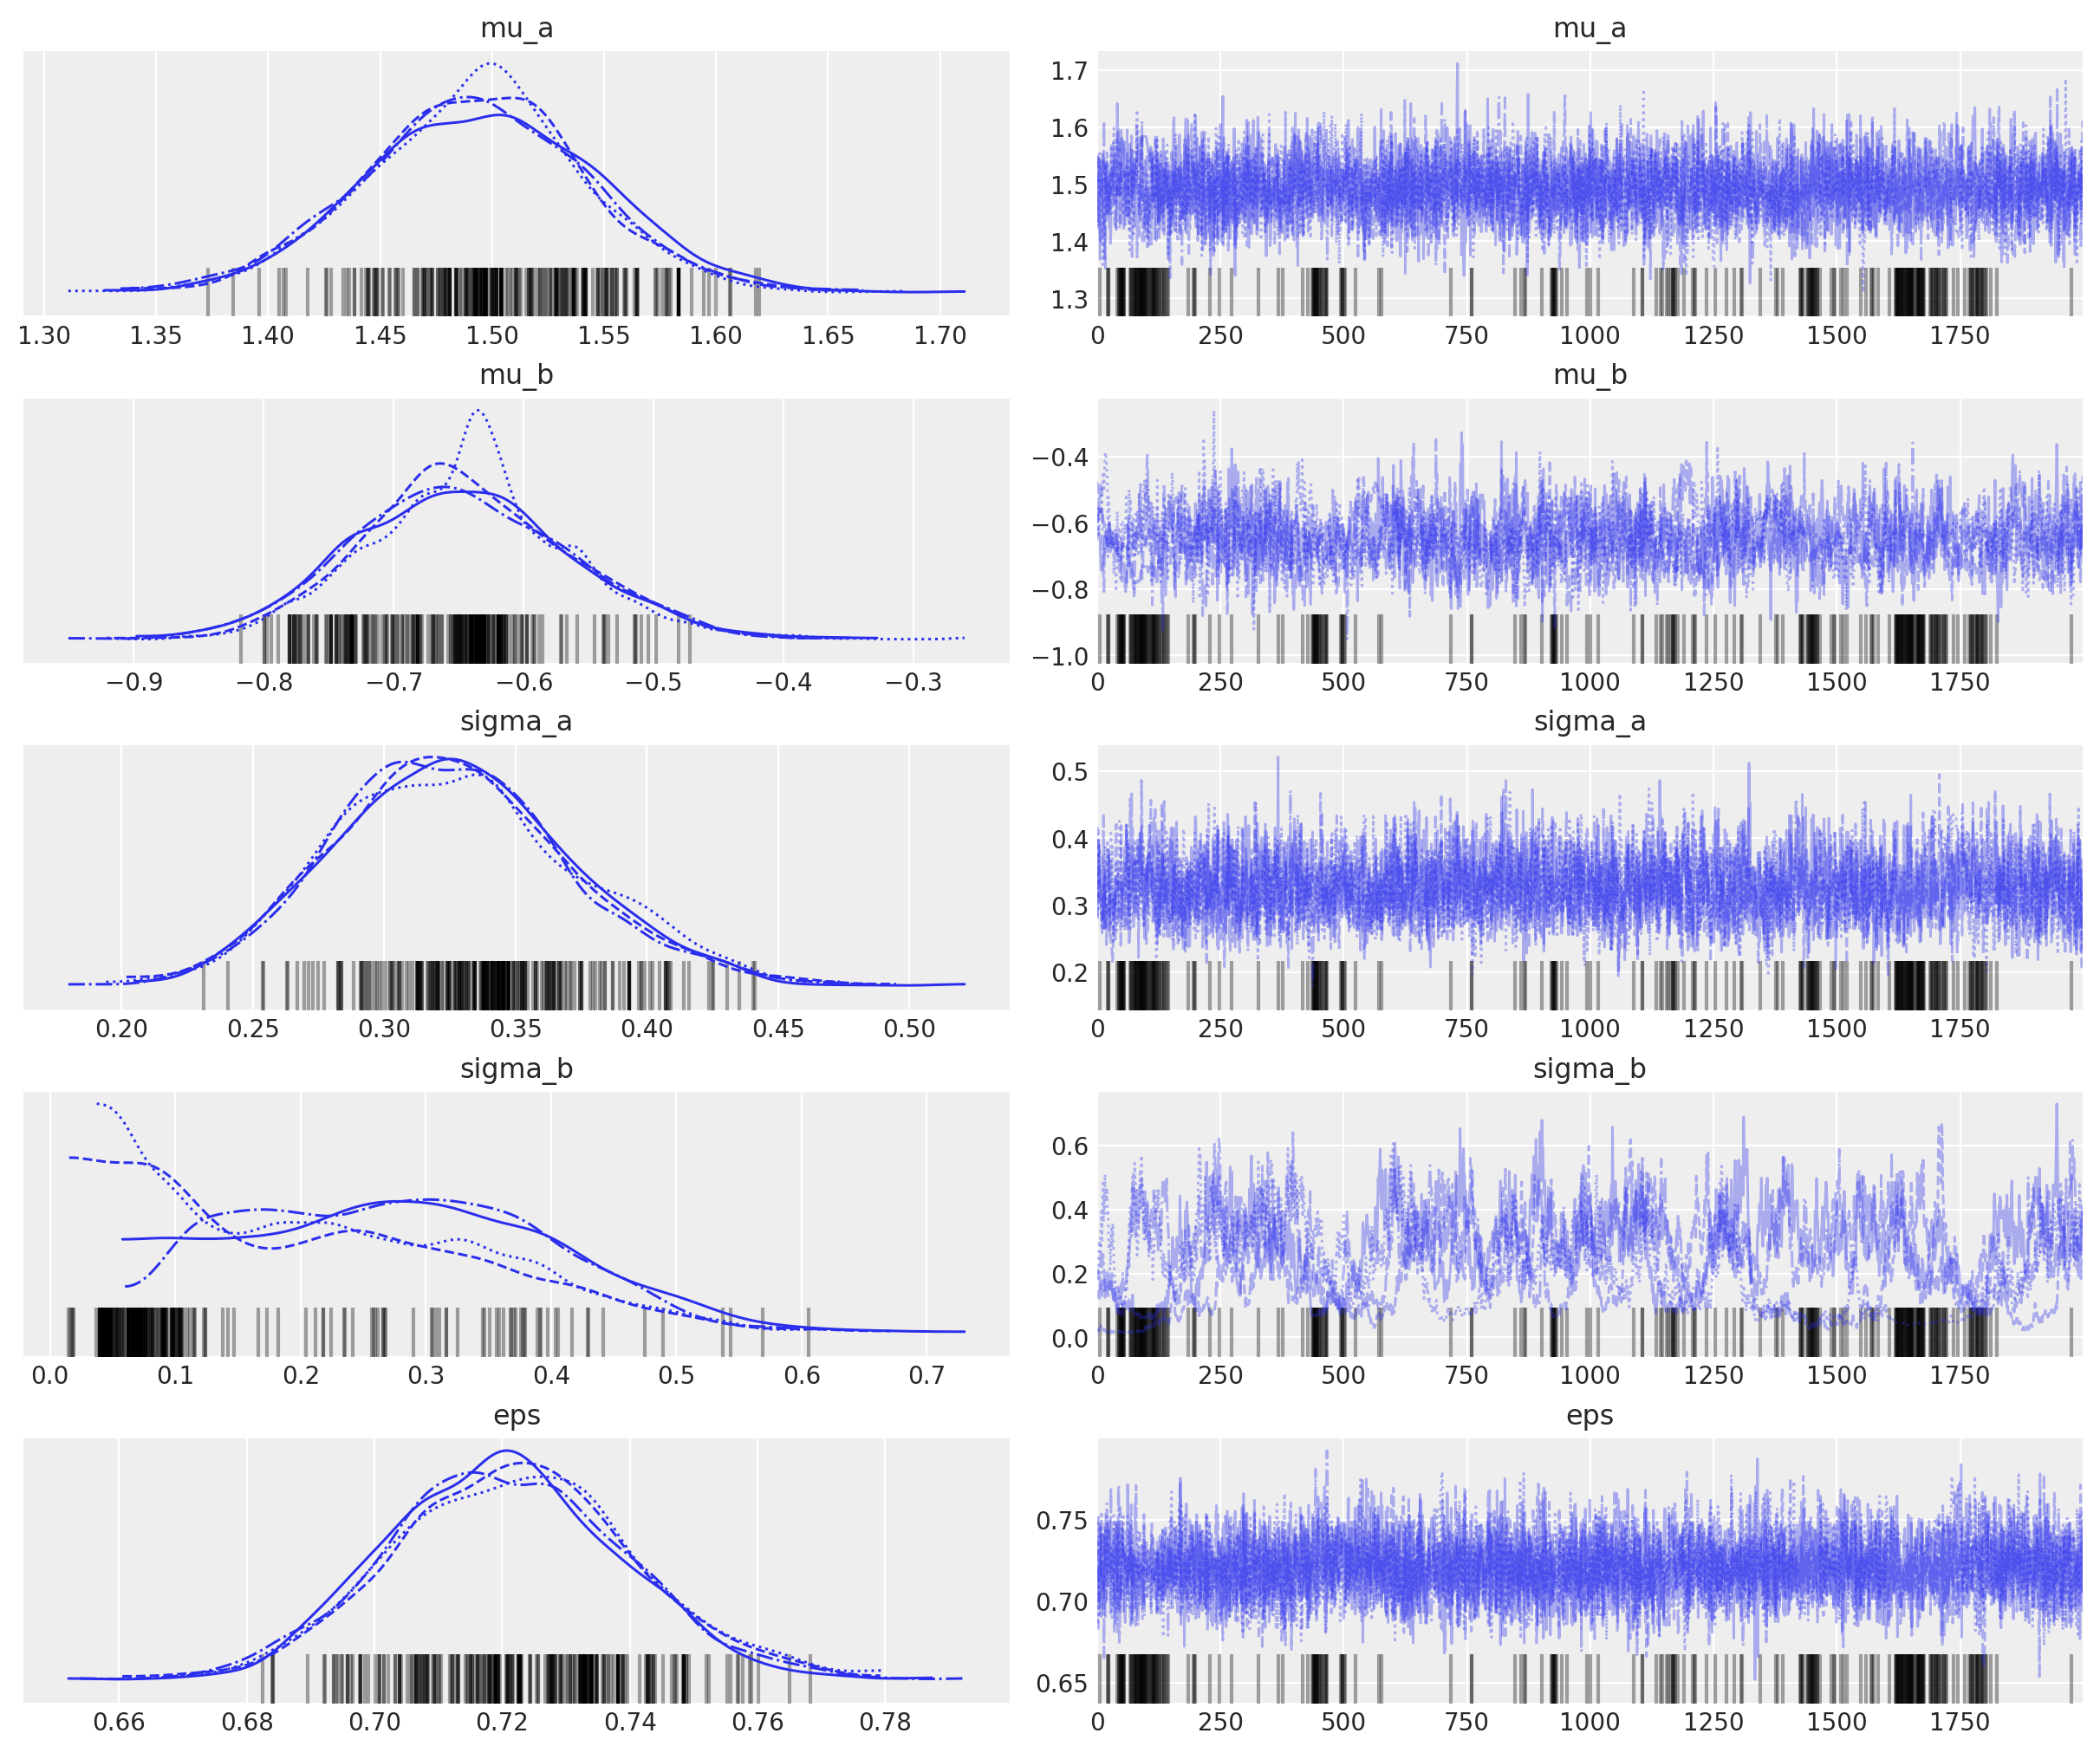

In [25]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

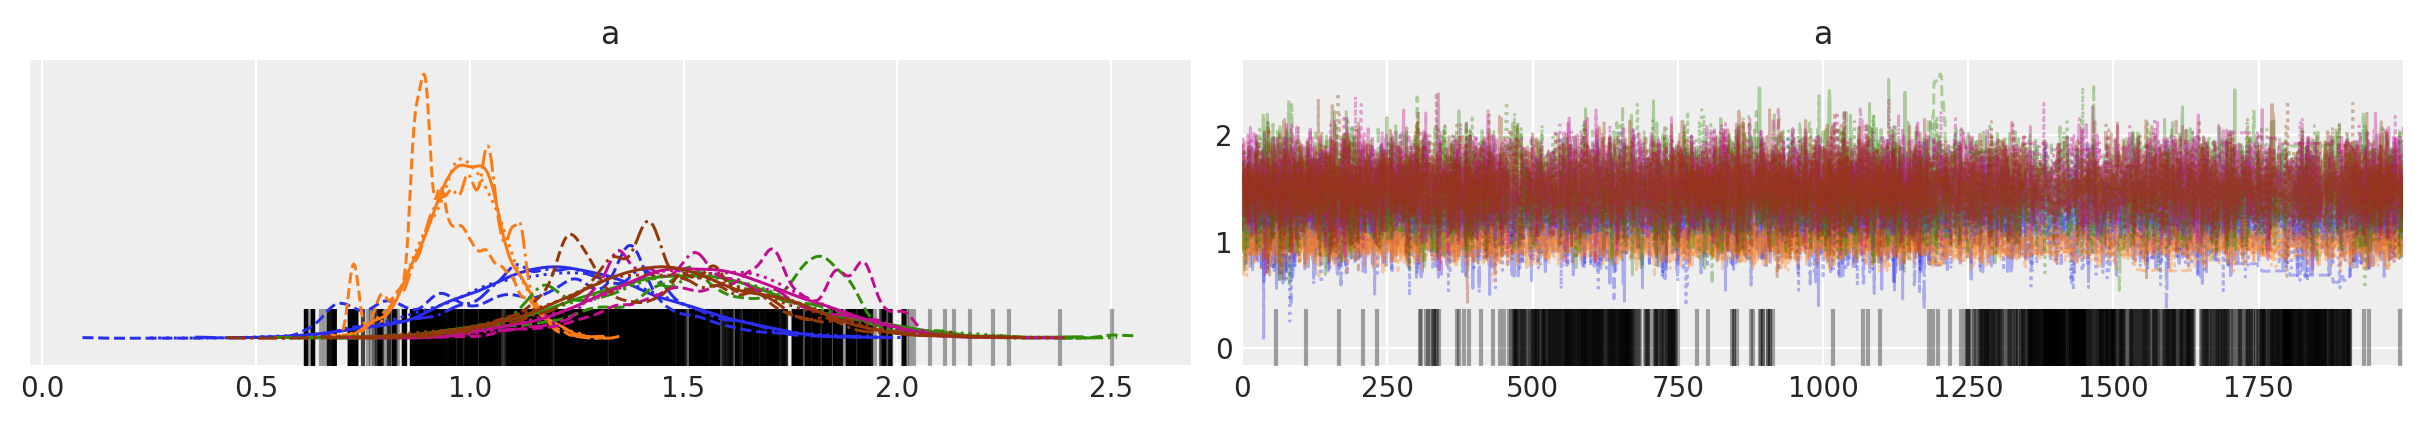

In [16]:
az.plot_trace(hierarchical_trace, var_names=["a"], coords={"county": counties[:5]})

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

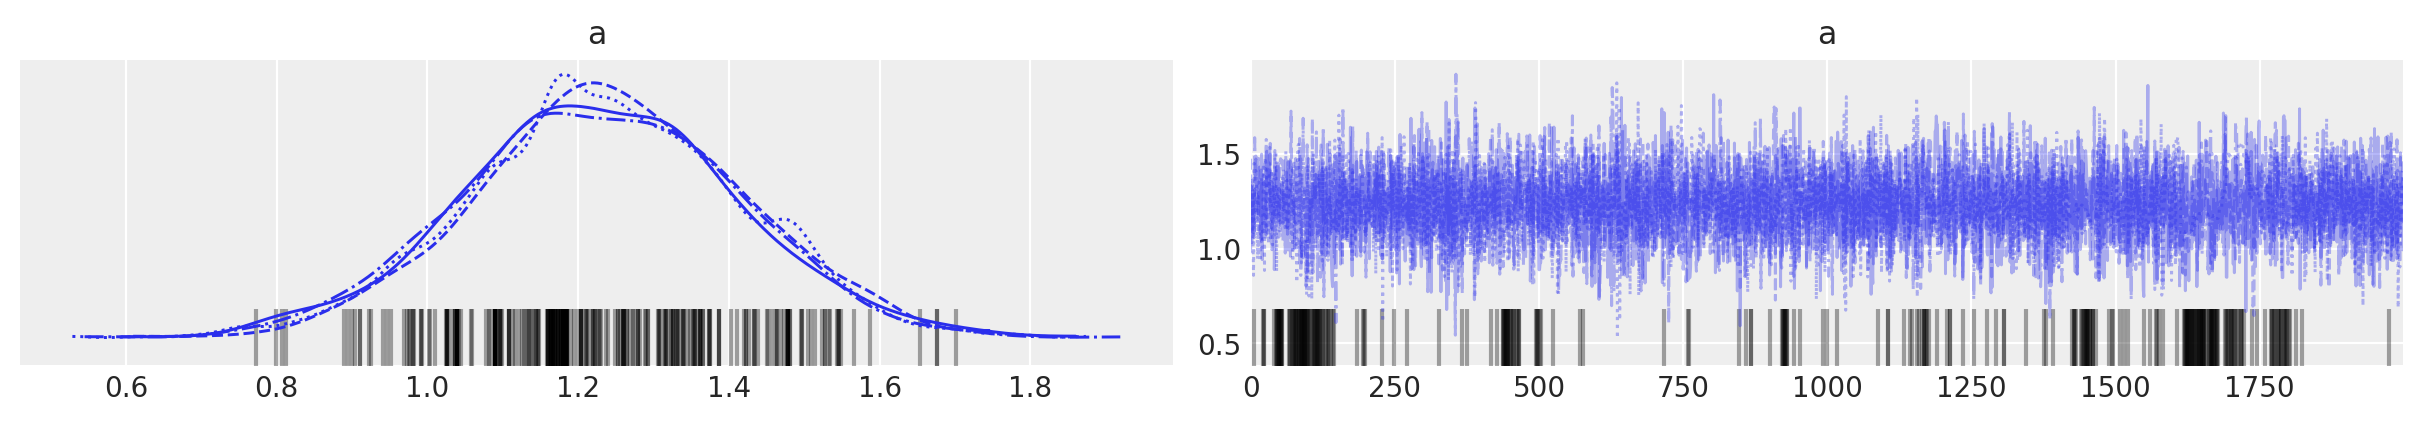

In [26]:

az.plot_trace(hierarchical_trace, var_names=["a"], coords={"county": counties[counties.get_loc("CROW WING")]})

In [27]:
selection = ["CASS", "CROW WING", "FREEBORN"]
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=85), dims=["x_plot"])

#unpooled_post = unpooled_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post = hierarchical_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post

<xarray.Dataset>
Dimensions:     (chain_draw: 8000, county: 85)
Coordinates:
  * county      (county) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables:
    mu_a        (chain_draw) float64 1.501 1.507 1.512 ... 1.55 1.464 1.467
    mu_b        (chain_draw) float64 -0.6507 -0.6329 -0.6382 ... -0.4988 -0.4581
    a           (county, chain_draw) float64 1.487 1.17 1.345 ... 1.16 1.654
    b           (county, chain_draw) float64 -0.7509 -0.5466 ... -0.4389 -1.067
    sigma_a     (chain_draw) float64 0.3431 0.3131 0.3705 ... 0.3135 0.3557
    sigma_b     (chain_draw) float64 0.1276 0.14 0.1382 ... 0.3294 0.3266 0.4169
    eps         (chain_draw) float64 0.7203 0.719 0.718 ... 0.7443 0.7058 0.7552
Attributes:
    created_at:                 2021-12-18T21:02:36.016755
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              71.49957990646362
    tuning_steps:               2000

In [19]:
hier_est = (hier_post["a"] + hier_post["b"] * xvals).transpose("x_plot", ...)
hier_est

<xarray.DataArray (x_plot: 85, county: 85, chain_draw: 8000)>
array([[[ 1.79966061,  1.8752469 ,  1.78377153, ...,  1.53156039,
          1.08466006,  1.46210585],
        [ 1.06137131,  1.13401156,  1.10719349, ...,  1.23646842,
          1.01547773,  1.10662523],
        [ 1.22594428,  1.14781446,  1.00893936, ...,  1.2049189 ,
          1.53835866,  1.77292334],
        ...,
        [ 1.49474419,  1.84813571,  1.89779192, ...,  2.38154706,
          1.71042693,  1.79839635],
        [ 1.60633129,  1.77138123,  1.68469121, ...,  1.69979552,
          1.66241501,  1.68762114],
        [ 1.56218276,  1.83056994,  1.8775227 , ...,  1.7430745 ,
          1.11707741,  1.35905211]],

       [[ 1.79292114,  1.86505066,  1.76773317, ...,  1.52098547,
          1.08193496,  1.45457557],
        [ 1.05150322,  1.121403  ,  1.09274795, ...,  1.21993562,
          1.00617177,  1.09586316],
        [ 1.21573884,  1.13672276,  0.99938747, ...,  1.20338135,
          1.52549563,  1.75942961],
...
        [ 0.59104155,  0.76760542,  0.89786171, ...,  0.15212507,
         -0.04552273, -0.19049537],
        [ 0.80324359,  0.8646611 ,  0.927095  , ...,  0.612232  ,
          0.88040705, -0.04047767],
        [ 0.74386129,  0.97432339,  0.86413864, ...,  1.05391342,
          0.24120102,  0.36608178]],

       [[ 1.23354537,  1.01876306,  0.43654904, ...,  0.64326721,
          0.85575134,  0.82956219],
        [ 0.23245132,  0.07489237, -0.10623218, ..., -0.1522868 ,
          0.23377769,  0.20261118],
        [ 0.3686876 ,  0.21611144,  0.20658044, ...,  1.07576509,
          0.4578641 ,  0.63945   ],
        ...,
        [ 0.58015356,  0.75458699,  0.88581436, ...,  0.12526457,
         -0.06667875, -0.21445792],
        [ 0.79356784,  0.85373676,  0.91796734, ...,  0.59912882,
          0.87098527, -0.06129813],
        [ 0.734002  ,  0.96400717,  0.85192919, ...,  1.04561027,
          0.23064829,  0.35411828]]])
Coordinates:
  * county      (county) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: x_plot

In [20]:
rng = np.random.default_rng(0)
rng

Generator(PCG64) at 0x7F6B1F80B120

NameError: name 'unpooled_est' is not defined

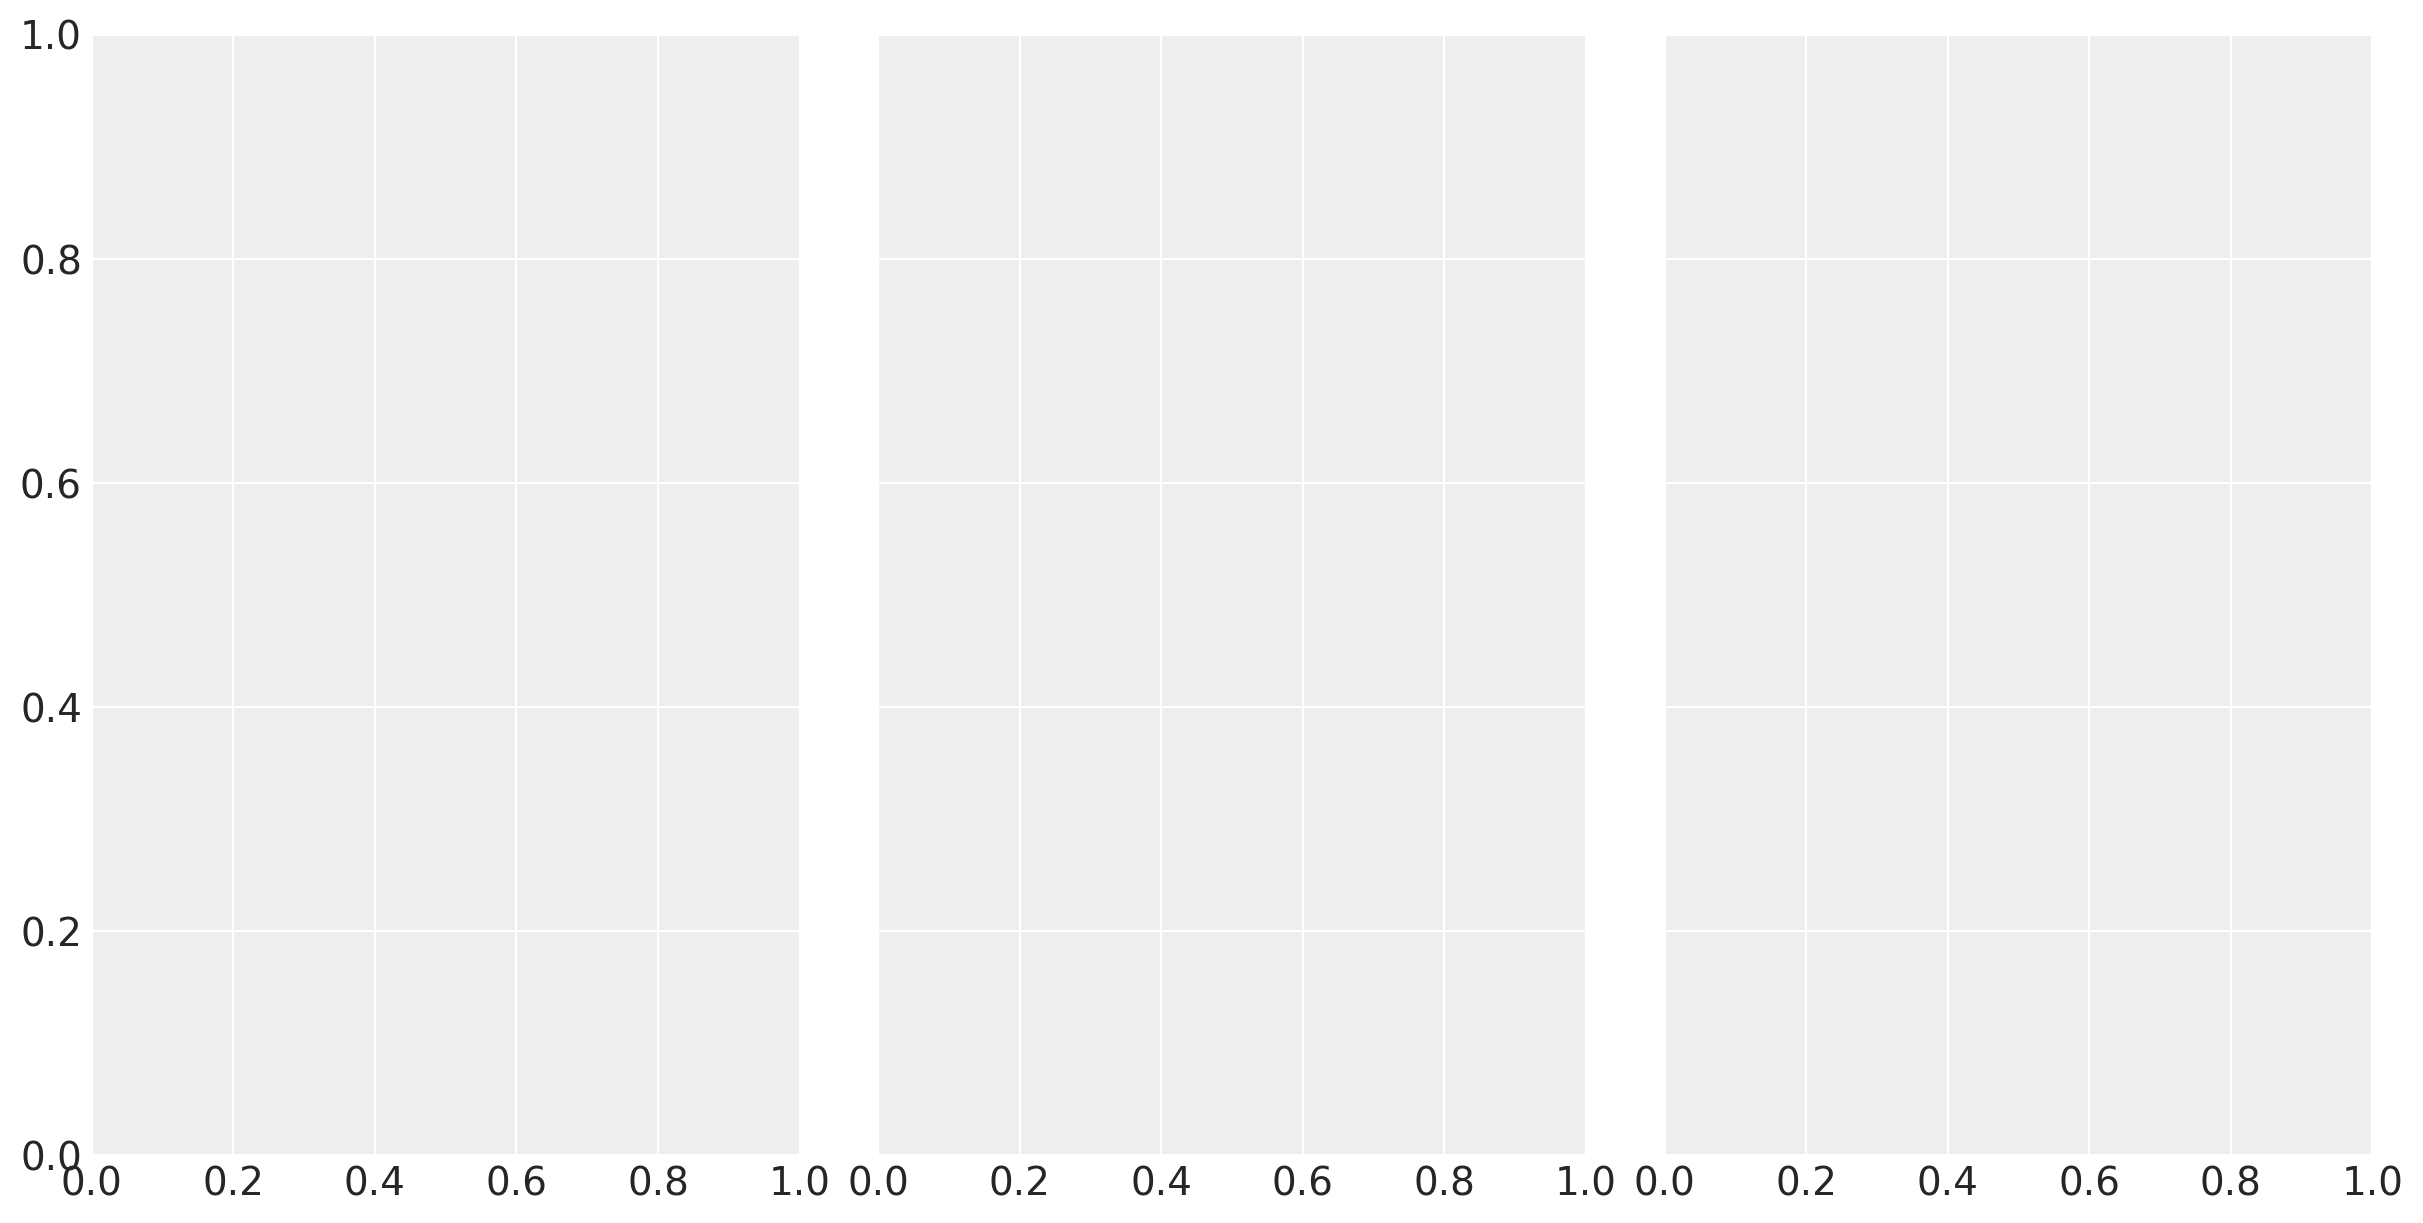

In [21]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]

for i, c in enumerate(selection):
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    ### hierarchical model ##
    hier_c = hier_est.sel(county=c)
    hier_means = hier_post.sel(county=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(selection), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")